# 0.7_ensemble

In [1]:
%run util.py

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
iris = datasets.load_iris()

In [4]:
X, y = iris.data[50:, [1, 2]], iris.target[50:]

In [5]:
le = LabelEncoder()

In [6]:
y = le.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

In [9]:
clf1 = LogisticRegression(
    penalty='l2',
    C = 0.001,
    random_state=1
)

In [10]:
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)

In [11]:
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric="minkowski")

In [17]:
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])

In [18]:
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

In [16]:
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

In [20]:
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f"ROC AUC {scores.mean():.2f} +/- {scores.std():.2f} [{label}]")

ROC AUC 0.92 +/- 0.15 [Logistic regression]
ROC AUC 0.87 +/- 0.18 [Decision tree]
ROC AUC 0.85 +/- 0.13 [KNN]


In [21]:
from src.majority_vote_classifier import MajorityVoteClassifier

In [22]:
mv_clf =  MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

In [23]:
clf_labels += ['Majority voting']

In [24]:
all_clf = [pipe1, clf2, pipe3, mv_clf]

In [26]:
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f"ROC AUC {scores.mean():.2f} +/- {scores.std():.2f} [{label}]")

ROC AUC 0.92 +/- 0.15 [Logistic regression]
ROC AUC 0.87 +/- 0.18 [Decision tree]
ROC AUC 0.85 +/- 0.13 [KNN]
ROC AUC 0.98 +/- 0.05 [Majority voting]


In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [28]:
colors = ['black', 'orange', 'blue', 'green']

In [29]:
linestyles = [':', '--', '-.', '-']

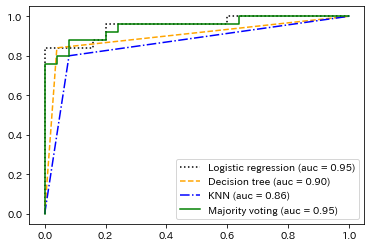

In [30]:
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # positive class should be 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label=f"{label} (auc = {roc_auc:.2f})")
plt.legend()

In [31]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

In [32]:
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

In [33]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

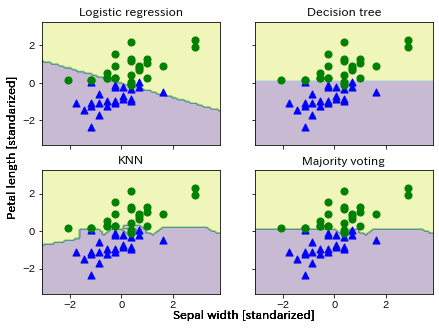

In [42]:
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=.3)
    axarr[idx[0], idx[1]].scatter(
        X_train_std[y_train==0, 0],
        X_train_std[y_train==0, 1],
        c = 'blue',
        marker = '^',
        s = 50
    )
    axarr[idx[0], idx[1]].scatter(
        X_train_std[y_train==1, 0],
        X_train_std[y_train==1, 1],
        c = 'green',
        marker = 'o',
        s = 50
    )
    axarr[idx[0], idx[1]].set_title(tt)
    plt.text(-3.5, -4.5, s='Sepal width [standarized]', ha='center', va='center', fontsize=12)
    plt.text(-12.5, 4.5, s='Petal length [standarized]', ha='center', va='center', fontsize=12, rotation=90)




In [43]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ['clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=1,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False)]],
          verbose=False),
 'decisiontreeclassifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split

In [47]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
                                                                    steps=[('sc',
                                                                            StandardScaler(copy=True,
                                                                                           with_mean=True,
                                                                                           with_std=True)),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               class_weight=None,
                                                                                               dual=False,
                                                                           

In [58]:
cv_results = grid.cv_results_

In [61]:
print(cv_results.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_decisiontreeclassifier__max_depth', 'param_pipeline-1__clf__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [67]:
params = cv_results['params']
means = cv_results['mean_test_score']
stds = cv_results['std_test_score']

In [72]:
for param, mean_score, std in zip(params, means, stds):
    print(f"{mean_score:.3f} +/- {std:.2f} {param}")

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [74]:
df_wine = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None)

In [76]:
df_wine.columns = ['class label', 'alcohol', 'malic acid', 'ash', 'alcalinity of ash', 'magnesium', 'total phenols',
                  'flavanoids', 'nonflavanoid phenols', 'proanthocyanins', 'color intensity', 'hue', 'od280/od315 of diluted wines', 'proline']
df_wine.columns = [word.capitalize() for word in df_wine.columns]

In [78]:
df_wine = df_wine[df_wine['Class label'] != 1]

In [81]:
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Od280/od315 of diluted wines']].values

In [89]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)


In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [98]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)

In [99]:
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

In [101]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f"{tree_train:.3f}, {tree_test:.3f}")

1.000, 0.833


In [102]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f"{tree_train:.3f}, {tree_test:.3f}")

1.000, 0.917


In [103]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

In [104]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

In [109]:
all_clf = [tree, bag]
clf_labels = ['Decision tree', "Bagging"]

Text(10.2, -1.2, 'Od280/od315 of diluted wines')

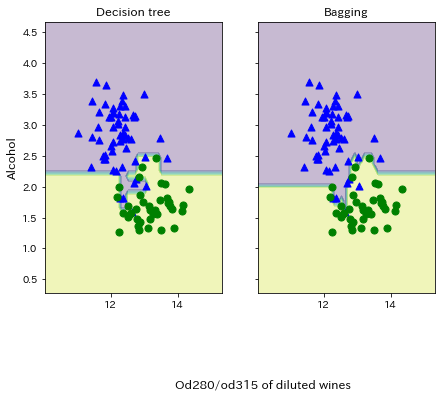

In [110]:
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(7, 5))
for idx, clf, tt in zip([0, 1], all_clf, clf_labels):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=.3)
    axarr[idx].scatter(
        X_train[y_train==0, 0],
        X_train[y_train==0, 1],
        c = 'blue',
        marker = '^',
        s = 50
    )
    axarr[idx].scatter(
        X_train[y_train==1, 0],
        X_train[y_train==1, 1],
        c = 'green',
        marker = 'o',
        s = 50
    )
    axarr[idx].set_title(tt)
axarr[0].set_ylabel("Alcohol", fontsize=12)
plt.text(10.2, -1.2, s='Od280/od315 of diluted wines', ha='center', va='center', fontsize=12)





In [113]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
tree = tree.fit(X_train, y_train)

In [114]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test) 
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

In [115]:
print(f"Decistion tree train/test accuracies: {tree_train:.3f}, {tree_test:.3f}")


Decistion tree train/test accuracies: 0.916, 0.875


In [118]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test) 
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

In [119]:
print(f"ada train/test accuracies: {ada_train:.3f}, {ada_test:.3f}")

ada train/test accuracies: 1.000, 0.917
